In [10]:
# external imports, keep as is
import sys
import os
import matplotlib.pyplot as plt

ROOT_PATH = os.path.abspath(".").split("src")[0]
if ROOT_PATH not in sys.path:
    sys.path.append(ROOT_PATH)
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.utils.utilities as utilities
import src.utils.models as models

# specific imports, use as needed
from src.ml.analysis.covmat import (covmat, printCovMat)
from src.ml.analysis.pca import (pca, printExplainedVarianceRatio)

In [11]:
# define dataset specifics

# path to dataset file, in .csv format
filename = "../HX-condition-monitoring/datasets/D/data.csv"

# list of dataset columns, format [columnName, columnDescription, columnUnit]
columns = [
    ['20TT001', 'Gas side inlet temperature', 'degrees'],
    ['20PT001', 'Gas side inlet pressure', 'barG'],
    ['20FT001', 'Gas side flow', 'M^3/s'],
    ['20TT002', 'Gas side outlet temperature', 'degrees'],
    ['20PDT001', 'Gas side pressure difference', 'bar'],
    ['50TT001', 'Cooling side inlet temperature', 'degrees'],
    ['50PT001', 'Cooling side inlet pressure', 'barG'],
    ['50FT001', 'Cooling side flow', 'M^3/s'],
    ['50TT002', 'Cooling side outlet temperature', 'degrees'],
    ['50PDT001', 'Cooling side pressure differential', 'bar'],
    ['50TV001', 'Cooling side valve opening', '%'],
]

# list of irrelevant dataset columns, not used for training or testing
irrelevantColumns = [
    '50FT001',
    '50PDT001',
    '20PDT001',
    '50TV001',
]

# list of target columns
targetColumns = [
    '50TT002',
]

In [12]:
names = list(map(lambda el: el[0], columns))
descriptions = list(map(lambda el: el[1], columns))
units = list(map(lambda el: el[2], columns))

relevantColumns = list(filter(lambda col: col not in irrelevantColumns, map(lambda el: el[0], columns)))
columnUnits = dict(zip(names, units))
columnDescriptions = dict(zip(names, descriptions))

In [20]:
# interval(s) of dataset used for training
traintime = [
        ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
    ]

# interval of dataset used for testing
# recommended: entire dataset
testtime = [
    "2020-01-01 00:00:00",
    "2020-07-01 00:00:00"
]

In [21]:
# machine learning arguments

"""
activation: default activation function used for trained models
loss: metric minimized during training
optimizer: machine learning optimizing scheme, determines how training is done
metrics: metrics measured during training
epochs: number of entire passes through training data
batchSize: number of training samples used before weights are updated once
verbose: determines model output during training
callbacks: used to interrupt or alter training process based on various conditions
enrolWindow: number of samples used by recurrent units to make each prediction
validationSize: number of training samples used for validation (where relevant)
testSize: number of training samples used for testing (where relevant)
"""

args = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 1,
    'callbacks': utilities.getBasicCallbacks(),
    'enrolWindow': 16,
    'validationSize': 0.2,
    'testSize': 0.2,
})

lstmArgs = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 1,
    'callbacks': utilities.getBasicCallbacks(monitor="loss"),
    'enrolWindow': 1,
    'validationSize': 0.2,
    'testSize': 0.2
})

lstmArgs2 = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 1,
    'callbacks': utilities.getBasicCallbacks(monitor="loss"),
    'enrolWindow': 16,
    'validationSize': 0.2,
    'testSize': 0.2
})

In [22]:
df = utilities.initDataframe(filename, relevantColumns, columnDescriptions)
df_train, df_test = utilities.getTestTrainSplit(df, traintime, testtime)
X_train, y_train, X_test, y_test = utilities.getFeatureTargetSplit(df_train, df_test, targetColumns)

0      01.01.2020 12:00
1      01.01.2020 18:00
2      02.01.2020 00:00
3      02.01.2020 06:00
4      02.01.2020 12:00
             ...       
477    29.04.2020 18:00
478    30.04.2020 00:00
479    30.04.2020 06:00
480    30.04.2020 12:00
481    30.04.2020 18:00
Name: Date, Length: 482, dtype: object
Date index set
Columns before removal
-------------------------------------------
Dataset columns:
Col. 0 : Index
Col. 1 : 20TT001 - Gas side inlet temperature
Col. 2 : 20PT001 - Gas side inlet pressure
Col. 3 : 20FT001 - Gas side flow
Col. 4 : 20TT002 - Gas side outlet temperature
Col. 5 : 20PDT001 - Gas side pressure difference
Col. 6 : 50TT001 - Cooling side inlet temperature
Col. 7 : 50PT001 - Cooling side inlet pressure
Col. 8 : 50FT001 - Cooling side flow
Col. 9 : 50TT002 - Cooling side outlet temperature
Col. 10 : 50PDT001 - Cooling side pressure differential
Col. 11 : 50TV001 - Cooling side valve opening
-------------------------------------------
Columns after removal
-----------

In [23]:
keras_seq_mod_regl = models.kerasSequentialRegressionModelWithRegularization(
    params={
        'name': '50 20 regularized',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [50, args.activation],
        [20, args.activation]
    ],
)
keras_seq_mod_simple = models.kerasSequentialRegressionModel(
    params={
        'name': '20 normal',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [20, args.activation]
    ],
)
keras_seq_mod_v_simple = models.kerasSequentialRegressionModel(
    params={
        'name': '0 Simple',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [X_train.shape[1], args.activation]
    ], 
)
keras_seq_mod = models.kerasSequentialRegressionModel(
    params={
        'name': '50 20 normal',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [50, args.activation],
        [20, args.activation]
    ]
)
lstmModel = models.kerasLSTMSingleLayerLeaky(
    params={
        'name': 'LSTM 128',
        'X_train': X_train,
        'y_train': y_train,
        'args': lstmArgs,
    },
    units=128,
    dropout=0.1,
    alpha=0.5
)
lstmModel2 = models.kerasLSTMSingleLayerLeaky(
    params={
        'name': 'LSTM 2 128',
        'X_train': X_train,
        'y_train': y_train,
        'args': lstmArgs2,
    },
    units=128,
    dropout=0.1,
    alpha=0.5
)
sklearnLinearModel = models.sklearnRidgeCV(
    params={
        'name': 'Linear',
        'X_train': X_train,
        'y_train': y_train,
    },
) 
ensemble = models.ensembleModel(
    params={
        'name': 'ensemble 4 mods',
        'X_train': X_train,
        'y_train': y_train,
    },
    models=[
        keras_seq_mod_regl,
        keras_seq_mod_simple,
        lstmModel,
        sklearnLinearModel,
    ],
)

In [24]:
modelList = [
    keras_seq_mod,
    keras_seq_mod_simple,
    ensemble,
    lstmModel,
    sklearnLinearModel,
]

retrain = True
maxEnrolWindow = utilities.findMaxEnrolWindow(modelList)

In [25]:
utilities.trainModels(modelList, filename, targetColumns, retrain)
names, r2_train, r2_test, deviationsList, columnsList = utilities.predictWithModels(
    modelList,
    X_train,
    y_train,
    X_test,
    y_test,
    targetColumns
)
utilities.saveModels(modelList, filename, targetColumns)

Training model 50 20 normal
Train on 98 samples, validate on 25 samples
Epoch 1/50
98/98 [==============================] - 0s 949us/step - loss: 0.8203 - mean_squared_error: 0.8203 - val_loss: 1.0948 - val_mean_squared_error: 1.0948
Epoch 2/50
98/98 [==============================] - 0s 102us/step - loss: 0.7184 - mean_squared_error: 0.7184 - val_loss: 1.0143 - val_mean_squared_error: 1.0143
Epoch 3/50
98/98 [==============================] - 0s 102us/step - loss: 0.6344 - mean_squared_error: 0.6344 - val_loss: 0.9451 - val_mean_squared_error: 0.9451
Epoch 4/50
98/98 [==============================] - 0s 92us/step - loss: 0.5565 - mean_squared_error: 0.5565 - val_loss: 0.8819 - val_mean_squared_error: 0.8819
Epoch 5/50
98/98 [==============================] - 0s 97us/step - loss: 0.4832 - mean_squared_error: 0.4832 - val_loss: 0.8165 - val_mean_squared_error: 0.8165
Epoch 6/50
98/98 [==============================] - 0s 107us/step - loss: 0.4176 - mean_squared_error: 0.4176 - val_loss

Train on 98 samples, validate on 25 samples
Epoch 1/50
98/98 [==============================] - 0s 740us/step - loss: 1.3514 - mean_squared_error: 1.3514 - val_loss: 0.9201 - val_mean_squared_error: 0.9201
Epoch 2/50
98/98 [==============================] - 0s 87us/step - loss: 1.2627 - mean_squared_error: 1.2627 - val_loss: 0.8889 - val_mean_squared_error: 0.8889
Epoch 3/50
98/98 [==============================] - 0s 97us/step - loss: 1.1908 - mean_squared_error: 1.1908 - val_loss: 0.8579 - val_mean_squared_error: 0.8579
Epoch 4/50
98/98 [==============================] - 0s 87us/step - loss: 1.1174 - mean_squared_error: 1.1174 - val_loss: 0.8316 - val_mean_squared_error: 0.8316
Epoch 5/50
98/98 [==============================] - 0s 97us/step - loss: 1.0522 - mean_squared_error: 1.0522 - val_loss: 0.8069 - val_mean_squared_error: 0.8069
Epoch 6/50
98/98 [==============================] - 0s 82us/step - loss: 0.9889 - mean_squared_error: 0.9889 - val_loss: 0.7841 - val_mean_squared_err

98/98 [==============================] - 0s 1ms/step - loss: 4.1615 - mean_squared_error: 0.8945 - val_loss: 3.5204 - val_mean_squared_error: 0.7957
Epoch 2/50
98/98 [==============================] - 0s 107us/step - loss: 3.9877 - mean_squared_error: 0.7983 - val_loss: 3.4084 - val_mean_squared_error: 0.7395
Epoch 3/50
98/98 [==============================] - 0s 97us/step - loss: 3.7349 - mean_squared_error: 0.7121 - val_loss: 3.3111 - val_mean_squared_error: 0.6957
Epoch 4/50
98/98 [==============================] - 0s 107us/step - loss: 3.6102 - mean_squared_error: 0.6390 - val_loss: 3.2217 - val_mean_squared_error: 0.6608
Epoch 5/50
98/98 [==============================] - 0s 97us/step - loss: 3.4365 - mean_squared_error: 0.5754 - val_loss: 3.1398 - val_mean_squared_error: 0.6296
Epoch 6/50
98/98 [==============================] - 0s 112us/step - loss: 3.3232 - mean_squared_error: 0.5207 - val_loss: 3.0694 - val_mean_squared_error: 0.5999
Epoch 7/50
98/98 [=========================

98/98 [==============================] - 0s 765us/step - loss: 0.0456 - mean_squared_error: 0.0456 - val_loss: 0.4883 - val_mean_squared_error: 0.4883
Epoch 2/50
98/98 [==============================] - 0s 97us/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.4906 - val_mean_squared_error: 0.4906
Epoch 3/50
98/98 [==============================] - 0s 92us/step - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.4927 - val_mean_squared_error: 0.4927
Epoch 4/50
98/98 [==============================] - 0s 87us/step - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.4914 - val_mean_squared_error: 0.4914
Epoch 5/50
98/98 [==============================] - 0s 92us/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.4841 - val_mean_squared_error: 0.4841
Epoch 6/50
98/98 [==============================] - 0s 87us/step - loss: 0.0253 - mean_squared_error: 0.0253 - val_loss: 0.4733 - val_mean_squared_error: 0.4733
Epoch 7/50
98/98 [==========================

Epoch 2/50
4/4 [==============================] - 0s 4ms/step - loss: 0.9083 - mean_squared_error: 0.9154
Epoch 3/50
4/4 [==============================] - 0s 4ms/step - loss: 0.8623 - mean_squared_error: 0.8679
Epoch 4/50
4/4 [==============================] - 0s 4ms/step - loss: 0.8184 - mean_squared_error: 0.8234
Epoch 5/50
4/4 [==============================] - 0s 4ms/step - loss: 0.7849 - mean_squared_error: 0.7912
Epoch 6/50
4/4 [==============================] - 0s 3ms/step - loss: 0.7393 - mean_squared_error: 0.7441
Epoch 7/50
4/4 [==============================] - 0s 4ms/step - loss: 0.7019 - mean_squared_error: 0.7067
Epoch 8/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6626 - mean_squared_error: 0.6667
Epoch 9/50
4/4 [==============================] - 0s 4ms/step - loss: 0.6336 - mean_squared_error: 0.6383
Epoch 10/50
4/4 [==============================] - 0s 4ms/step - loss: 0.5918 - mean_squared_error: 0.5953
Epoch 11/50
4/4 [============================

4/4 [==============================] - 0s 4ms/step - loss: 0.0560 - mean_squared_error: 0.0558
Epoch 29/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0576 - mean_squared_error: 0.0572
Epoch 30/50
4/4 [==============================] - 0s 6ms/step - loss: 0.0562 - mean_squared_error: 0.0559
Epoch 31/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0524 - mean_squared_error: 0.0522
Epoch 32/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0548 - mean_squared_error: 0.0545
Epoch 33/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0559 - mean_squared_error: 0.0556
Epoch 34/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0503 - mean_squared_error: 0.0502
Epoch 35/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0558 - mean_squared_error: 0.0553
Epoch 36/50
4/4 [==============================] - 0s 4ms/step - loss: 0.0574 - mean_squared_error: 0.0571
Epoch 37/50
4/4 [==============================] 

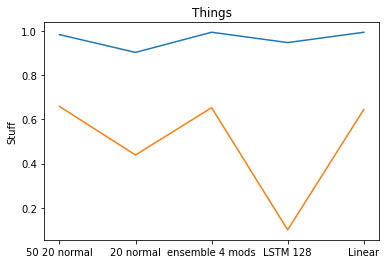

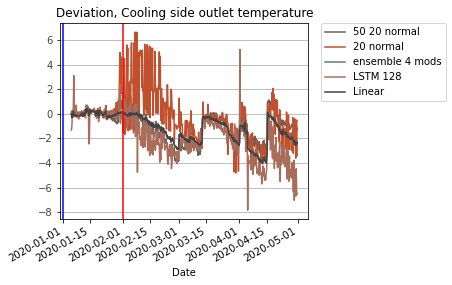

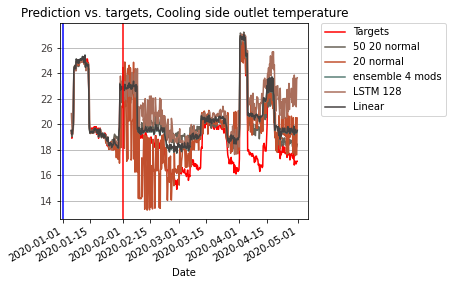

In [26]:
utilities.printModelPredictions(names, r2_train, r2_test)
utilities.plotModelPredictions(
    plt,
    deviationsList,
    columnsList,
    df_test.iloc[maxEnrolWindow:].index,
    columnDescriptions,
    traintime
)